## Etape 1

In [3]:
# Installation de pgmpy pour les réseaux bayésiens
!pip install pgmpy matplotlib networkx

import pandas as pd
import numpy as np
from pgmpy.models import DiscreteBayesianNetwork  # <-- Changement ici
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import matplotlib.pyplot as plt
import networkx as nx

Defaulting to user installation because normal site-packages is not writeable


## Etape 2

In [5]:
# ============ POLYARBRE ============
# Structure simple en arbre pour la surveillance système

print("=" * 70)
print("ÉTAPE 2 : POLYARBRE - SURVEILLANCE SYSTÈME SIMPLE")
print("=" * 70)

# Création du modèle polyarbre
polyarbre_securite = DiscreteBayesianNetwork([
    # Structure en arbre simple
    ('Accès_Réseau', 'Logs_Suspects'),
    ('Accès_Réseau', 'Trafic_Anormal'),
    ('Logs_Suspects', 'Alerte_Sécurité'),
    ('Trafic_Anormal', 'Alerte_Sécurité')
])

# Distributions a priori pour le nœud racine
cpd_acces_reseau = TabularCPD(
    variable='Accès_Réseau',
    variable_card=2,
    values=[[0.85], [0.15]],  # 15% de chance d'accès réseau suspect
    state_names={'Accès_Réseau': ['Normal', 'Suspect']}
)

# Distributions conditionnelles - POLYARBRE (chaque nœud a un seul parent)
cpd_logs_suspects = TabularCPD(
    variable='Logs_Suspects',
    variable_card=2,
    values=[
        [0.95, 0.30],  # P(Logs=Normal | Accès=Normal)=0.95, P(...|Suspect)=0.30
        [0.05, 0.70]   # P(Logs=Suspects | ...)
    ],
    evidence=['Accès_Réseau'],
    evidence_card=[2],
    state_names={
        'Logs_Suspects': ['Normal', 'Suspects'],
        'Accès_Réseau': ['Normal', 'Suspect']
    }
)

cpd_trafic_anormal = TabularCPD(
    variable='Trafic_Anormal',
    variable_card=2,
    values=[
        [0.90, 0.20],  # P(Trafic=Normal | Accès=Normal)=0.90, P(...|Suspect)=0.20
        [0.10, 0.80]   # P(Trafic=Anormal | ...)
    ],
    evidence=['Accès_Réseau'],
    evidence_card=[2],
    state_names={
        'Trafic_Anormal': ['Normal', 'Anormal'],
        'Accès_Réseau': ['Normal', 'Suspect']
    }
)

cpd_alerte_securite = TabularCPD(
    variable='Alerte_Sécurité',
    variable_card=2,
    values=[
        # P(Alerte=Non | Logs, Trafic) - Structure polyarbre (un seul parent n'affecte pas l'autre)
        # Logs: Normal, Suspects pour chaque Trafic
        [0.99, 0.60, 0.70, 0.10],  # Trafic Normal: Logs Normal, Suspects
        # Trafic Anormal: Logs Normal, Suspects
        [0.01, 0.40, 0.30, 0.90]   # P(Alerte=Oui | ...)
    ],
    evidence=['Logs_Suspects', 'Trafic_Anormal'],
    evidence_card=[2, 2],
    state_names={
        'Alerte_Sécurité': ['Non', 'Oui'],
        'Logs_Suspects': ['Normal', 'Suspects'],
        'Trafic_Anormal': ['Normal', 'Anormal']
    }
)

# Ajout des CPDs au modèle
polyarbre_securite.add_cpds(
    cpd_acces_reseau,
    cpd_logs_suspects,
    cpd_trafic_anormal,
    cpd_alerte_securite
)

# Vérification
print("✓ Modèle polyarbre vérifié:", polyarbre_securite.check_model())

# Inférence
inference_poly = VariableElimination(polyarbre_securite)

# Scénario 1: Calcul simple
print("\n" + "-" * 50)
print("SCÉNARIO 1 : Détection basique")
print("-" * 50)
print("Variable d'évidence: Accès_Réseau = 'Suspect'")
print("Variable d'intérêt: Alerte_Sécurité = 'Oui'")

result_poly1 = inference_poly.query(
    variables=['Alerte_Sécurité'],
    evidence={'Accès_Réseau': 'Suspect'}
)
prob_alerte = result_poly1.values[1]
print(f"P(Alerte=Oui | Accès_Suspect) = {prob_alerte:.3f} ({prob_alerte*100:.1f}%)")

# Scénario 2: Avec multiple évidences
print("\n" + "-" * 50)
print("SCÉNARIO 2 : Multiples indicateurs")
print("-" * 50)
print("Variables d'évidence:")
print("  - Logs_Suspects = 'Suspects'")
print("  - Trafic_Anormal = 'Anormal'")
print("Variable d'intérêt: Alerte_Sécurité = 'Oui'")

result_poly2 = inference_poly.query(
    variables=['Alerte_Sécurité'],
    evidence={
        'Logs_Suspects': 'Suspects',
        'Trafic_Anormal': 'Anormal'
    }
)
prob_alerte2 = result_poly2.values[1]
print(f"P(Alerte=Oui | Logs_Suspects, Trafic_Anormal) = {prob_alerte2:.3f} ({prob_alerte2*100:.1f}%)")

# Visualisation des probabilités conditionnelles
print("\n" + "-" * 50)
print("ANALYSE DES PROBABILITÉS CONDITIONNELLES")
print("-" * 50)

# Probabilité a priori
prior = inference_poly.query(variables=['Alerte_Sécurité'])
print(f"Probabilité a priori d'alerte: {prior.values[1]*100:.1f}%")

# Impact de chaque variable séparément
alerte_logs = inference_poly.query(
    variables=['Alerte_Sécurité'],
    evidence={'Logs_Suspects': 'Suspects'}
)
print(f"Avec logs suspects: {alerte_logs.values[1]*100:.1f}%")

alerte_trafic = inference_poly.query(
    variables=['Alerte_Sécurité'],
    evidence={'Trafic_Anormal': 'Anormal'}
)
print(f"Avec trafic anormal: {alerte_trafic.values[1]*100:.1f}%")

ÉTAPE 2 : POLYARBRE - SURVEILLANCE SYSTÈME SIMPLE
✓ Modèle polyarbre vérifié: True

--------------------------------------------------
SCÉNARIO 1 : Détection basique
--------------------------------------------------
Variable d'évidence: Accès_Réseau = 'Suspect'
Variable d'intérêt: Alerte_Sécurité = 'Oui'
P(Alerte=Oui | Accès_Suspect) = 0.643 (64.3%)

--------------------------------------------------
SCÉNARIO 2 : Multiples indicateurs
--------------------------------------------------
Variables d'évidence:
  - Logs_Suspects = 'Suspects'
  - Trafic_Anormal = 'Anormal'
Variable d'intérêt: Alerte_Sécurité = 'Oui'
P(Alerte=Oui | Logs_Suspects, Trafic_Anormal) = 0.900 (90.0%)

--------------------------------------------------
ANALYSE DES PROBABILITÉS CONDITIONNELLES
--------------------------------------------------
Probabilité a priori d'alerte: 15.1%
Avec logs suspects: 65.9%
Avec trafic anormal: 61.5%


ÉTAPE 2 : POLYARBRE - VISUALISATIONS

Debug: Shape de cpd_alerte_securite.values = (2, 2, 2)
Debug: Type de cpd_alerte_securite.values = <class 'numpy.ndarray'>
Combinaison 0: Logs=Normal, Trafic=Normal
  P(Non) = 0.990, P(Oui) = 0.010
Combinaison 1: Logs=Normal, Trafic=Anormal
  P(Non) = 0.600, P(Oui) = 0.400
Combinaison 2: Logs=Suspects, Trafic=Normal
  P(Non) = 0.700, P(Oui) = 0.300
Combinaison 3: Logs=Suspects, Trafic=Anormal
  P(Non) = 0.100, P(Oui) = 0.900


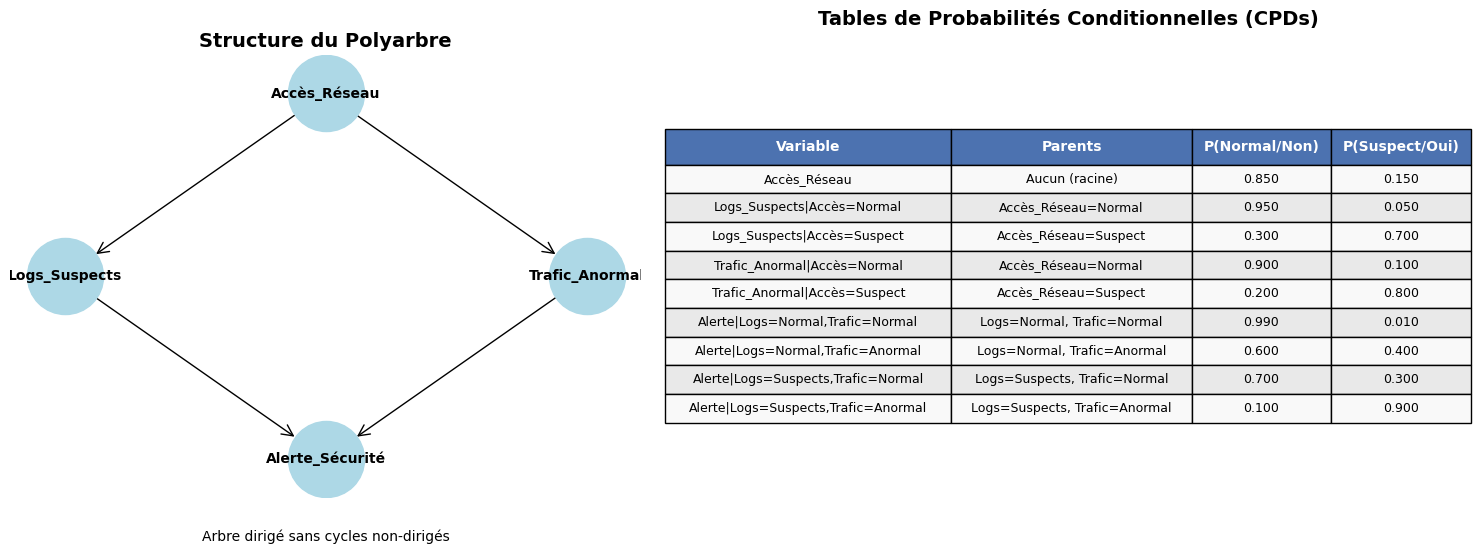


RÉSULTATS D'INFÉRENCE POUR LE POLYARBRE
Accès normal                   → P(Alerte=Oui) = 0.151 (15.1%)
Accès suspect                  → P(Alerte=Oui) = 0.643 (64.3%)
Logs suspects                  → P(Alerte=Oui) = 0.659 (65.9%)
Trafic anormal                 → P(Alerte=Oui) = 0.615 (61.5%)
Logs suspects + Trafic anormal → P(Alerte=Oui) = 0.900 (90.0%)


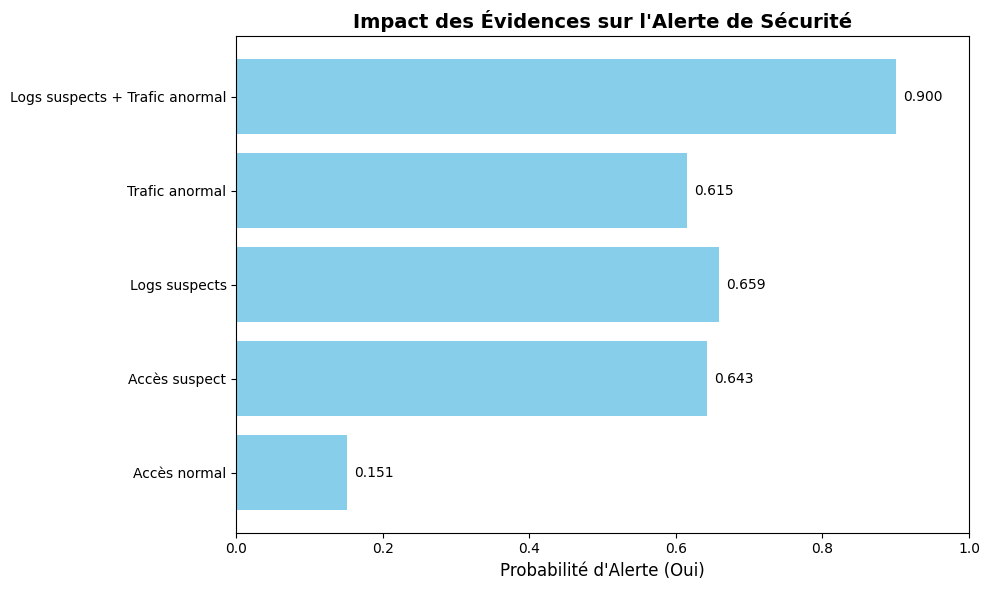

In [22]:
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

# ============ POLYARBRE ============
print("=" * 70)
print("ÉTAPE 2 : POLYARBRE - VISUALISATIONS")
print("=" * 70)

# Création du modèle (version corrigée)
polyarbre_securite = DiscreteBayesianNetwork([
    ('Accès_Réseau', 'Logs_Suspects'),
    ('Accès_Réseau', 'Trafic_Anormal'),
    ('Logs_Suspects', 'Alerte_Sécurité'),
    ('Trafic_Anormal', 'Alerte_Sécurité')
])

# Distributions (version corrigée)
cpd_acces_reseau = TabularCPD(
    variable='Accès_Réseau', variable_card=2,
    values=[[0.85], [0.15]],
    state_names={'Accès_Réseau': ['Normal', 'Suspect']}
)

cpd_logs_suspects = TabularCPD(
    variable='Logs_Suspects', variable_card=2,
    values=[[0.95, 0.30], [0.05, 0.70]],
    evidence=['Accès_Réseau'], evidence_card=[2],
    state_names={'Logs_Suspects': ['Normal', 'Suspects'],
                 'Accès_Réseau': ['Normal', 'Suspect']}
)

cpd_trafic_anormal = TabularCPD(
    variable='Trafic_Anormal', variable_card=2,
    values=[[0.90, 0.20], [0.10, 0.80]],
    evidence=['Accès_Réseau'], evidence_card=[2],
    state_names={'Trafic_Anormal': ['Normal', 'Anormal'],
                 'Accès_Réseau': ['Normal', 'Suspect']}
)

cpd_alerte_securite = TabularCPD(
    variable='Alerte_Sécurité', variable_card=2,
    values=[[0.99, 0.60, 0.70, 0.10],
            [0.01, 0.40, 0.30, 0.90]],
    evidence=['Logs_Suspects', 'Trafic_Anormal'],
    evidence_card=[2, 2],
    state_names={'Alerte_Sécurité': ['Non', 'Oui'],
                 'Logs_Suspects': ['Normal', 'Suspects'],
                 'Trafic_Anormal': ['Normal', 'Anormal']}
)

polyarbre_securite.add_cpds(cpd_acces_reseau, cpd_logs_suspects, 
                           cpd_trafic_anormal, cpd_alerte_securite)

# ============ VISUALISATION 1 : GRAPHE DU RÉSEAU ============
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Sous-graphique 1 : Structure du réseau
ax1 = axes[0]
G = nx.DiGraph()

# Ajout des nœuds avec positions pour un polyarbre
pos = {
    'Accès_Réseau': (0, 1),
    'Logs_Suspects': (-1, 0),
    'Trafic_Anormal': (1, 0),
    'Alerte_Sécurité': (0, -1)
}

G.add_edges_from([
    ('Accès_Réseau', 'Logs_Suspects'),
    ('Accès_Réseau', 'Trafic_Anormal'),
    ('Logs_Suspects', 'Alerte_Sécurité'),
    ('Trafic_Anormal', 'Alerte_Sécurité')
])

# Dessin du graphe
nx.draw(G, pos, ax=ax1, with_labels=True, node_size=3000, 
        node_color='lightblue', font_size=10, font_weight='bold',
        arrowsize=20, arrowstyle='->')
ax1.set_title("Structure du Polyarbre", fontsize=14, fontweight='bold')
ax1.text(0.5, -0.1, "Arbre dirigé sans cycles non-dirigés", 
         transform=ax1.transAxes, ha='center', fontsize=10)

# ============ VISUALISATION 2 : TABLES DES PROBABILITÉS ============
ax2 = axes[1]
ax2.axis('off')  # Désactive les axes pour le tableau

# Préparation des données du tableau
table_data = []
headers = ["Variable", "Parents", "P(Normal/Non)", "P(Suspect/Oui)"]

# CPD pour Accès_Réseau (racine)
table_data.append([
    "Accès_Réseau", 
    "Aucun (racine)", 
    f"{cpd_acces_reseau.values[0]:.3f}", 
    f"{cpd_acces_reseau.values[1]:.3f}"
])

# CPD pour Logs_Suspects
for i, etat_acces in enumerate(['Normal', 'Suspect']):
    table_data.append([
        f"Logs_Suspects|Accès={etat_acces}",
        f"Accès_Réseau={etat_acces}",
        f"{cpd_logs_suspects.values[0][i]:.3f}",
        f"{cpd_logs_suspects.values[1][i]:.3f}"
    ])

# CPD pour Trafic_Anormal
for i, etat_acces in enumerate(['Normal', 'Suspect']):
    table_data.append([
        f"Trafic_Anormal|Accès={etat_acces}",
        f"Accès_Réseau={etat_acces}",
        f"{cpd_trafic_anormal.values[0][i]:.3f}",
        f"{cpd_trafic_anormal.values[1][i]:.3f}"
    ])

# CPD pour Alerte_Sécurité
# CPD pour Alerte_Sécurité - VERSION CORRIGÉE
combinaisons = [('Normal', 'Normal'), ('Normal', 'Anormal'), 
                ('Suspects', 'Normal'), ('Suspects', 'Anormal')]

print(f"\nDebug: Shape de cpd_alerte_securite.values = {cpd_alerte_securite.values.shape}")
print(f"Debug: Type de cpd_alerte_securite.values = {type(cpd_alerte_securite.values)}")

for idx, (logs, trafic) in enumerate(combinaisons):
    # Méthode 1 : Avec get_values() (recommandée)
    prob_non = cpd_alerte_securite.get_values()[0, idx]
    prob_oui = cpd_alerte_securite.get_values()[1, idx]
    
    # OU Méthode 2 : Avec .values et indexation numpy
    # prob_non = cpd_alerte_securite.values[0, idx]
    # prob_oui = cpd_alerte_securite.values[1, idx]
    
    # OU Méthode 3 : Convertir en liste d'abord
    # values_list = cpd_alerte_securite.values.tolist()
    # prob_non = values_list[0][idx]
    # prob_oui = values_list[1][idx]
    
    table_data.append([
        f"Alerte|Logs={logs},Trafic={trafic}",
        f"Logs={logs}, Trafic={trafic}",
        f"{float(prob_non):.3f}",  # Conversion explicite en float pour sécurité
        f"{float(prob_oui):.3f}"   # Conversion explicite en float pour sécurité
    ])
    
    # Debug print
    print(f"Combinaison {idx}: Logs={logs}, Trafic={trafic}")
    print(f"  P(Non) = {prob_non:.3f}, P(Oui) = {prob_oui:.3f}")

# Création du tableau
table = ax2.table(cellText=table_data, colLabels=headers,
                  cellLoc='center', loc='center',
                  colColours=['#f0f0f0']*4)

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.5)

# Style du tableau
# for i in range(len(table_data)+1):
#     for j in range(4):
#         cell = table[(i, j)]
#         if i == 0:  # En-tête
#             cell.set_facecolor('#4c72b0')
#             cell.set_text_props(weight='bold', color='white')
#         elif i in [1, 3, 5, 7, 9]:  # Lignes paires
#             cell.set_facecolor('#f9f9f9')
#         else:  # Lignes impaires
#             cell.set_facecolor('#e9e9e9')

# ax2.set_title("Tables de Probabilités Conditionnelles (CPDs)", 
#               fontsize=14, fontweight='bold', y=1.05)

# plt.tight_layout()
# plt.show()
# Création du tableau avec ajustement de la largeur
table = ax2.table(cellText=table_data, colLabels=headers,
                  cellLoc='center', loc='center',
                  colColours=['#f0f0f0']*4,
                  colWidths=[0.25, 0.35, 0.20, 0.20])  # AJOUT: Largeurs des colonnes

table.auto_set_font_size(False)
table.set_fontsize(9)

# Ajuster la hauteur des cellules
table.scale(1.2, 1.8)  # Augmenter le premier paramètre (largeur)

# Style du tableau avec ajustements
for i in range(len(table_data)+1):
    for j in range(4):
        cell = table[(i, j)]
        if i == 0:  # En-tête
            cell.set_facecolor('#4c72b0')
            cell.set_text_props(weight='bold', color='white', fontsize=10)
            # Augmenter la hauteur de l'en-tête
            cell.set_height(0.08)
        elif i in [1, 3, 5, 7, 9]:  # Lignes paires
            cell.set_facecolor('#f9f9f9')
        else:  # Lignes impaires
            cell.set_facecolor('#e9e9e9')
        
        # Ajuster le padding des cellules
        cell.PAD = 0.1

# Ajuster manuellement la position et la taille
table.auto_set_column_width(col=list(range(4)))  # Ajuster automatiquement les colonnes

# Ajuster la position pour mieux centrer
table._autoColumns = list(range(4))

ax2.set_title("Tables de Probabilités Conditionnelles (CPDs)", 
              fontsize=14, fontweight='bold', y=1.05)

# Ajuster les marges pour que le tableau ait plus d'espace
plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.05)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajuster le rectangle pour laisser de l'espace
plt.show()

# ============ VISUALISATION 3 : RÉSULTATS D'INFÉRENCE ============
print("\n" + "=" * 70)
print("RÉSULTATS D'INFÉRENCE POUR LE POLYARBRE")
print("=" * 70)

inference_poly = VariableElimination(polyarbre_securite)

# Scénarios d'inférence
scenarios = [
    ("Accès normal", {}),
    ("Accès suspect", {"Accès_Réseau": "Suspect"}),
    ("Logs suspects", {"Logs_Suspects": "Suspects"}),
    ("Trafic anormal", {"Trafic_Anormal": "Anormal"}),
    ("Logs suspects + Trafic anormal", 
     {"Logs_Suspects": "Suspects", "Trafic_Anormal": "Anormal"})
]

fig2, ax3 = plt.subplots(figsize=(10, 6))
scenario_names = []
prob_alertes = []

for nom, evidence in scenarios:
    result = inference_poly.query(variables=['Alerte_Sécurité'], 
                                  evidence=evidence if evidence else None)
    prob_oui = result.values[1]
    
    scenario_names.append(nom)
    prob_alertes.append(prob_oui)
    
    print(f"{nom:30} → P(Alerte=Oui) = {prob_oui:.3f} ({prob_oui*100:.1f}%)")

# Graphique à barres
bars = ax3.barh(scenario_names, prob_alertes, color='skyblue')
ax3.set_xlabel("Probabilité d'Alerte (Oui)", fontsize=12)
ax3.set_title("Impact des Évidences sur l'Alerte de Sécurité", 
              fontsize=14, fontweight='bold')

# Ajout des valeurs sur les barres
for bar, prob in zip(bars, prob_alertes):
    width = bar.get_width()
    ax3.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{prob:.3f}', ha='left', va='center')

ax3.set_xlim(0, 1)
plt.tight_layout()
plt.show()

In [21]:
# ============ AFFICHAGE DES CPDs DANS LA CONSOLE ============
print("\n" + "=" * 70)
print("AFFICHAGE DES TABLES CPD (PROBABILITÉS)")
print("=" * 70)

# Fonction SIMPLIFIÉE et CORRECTE pour afficher une CPD
def print_cpd_simple(cpd):
    """Affiche une CPD de manière simple et fiable"""
    print(f"\n{'='*50}")
    print(f"TABLE CPD: {cpd.variable}")
    print(f"{'='*50}")
    
    # Récupérer les valeurs en float
    values = cpd.get_values()
    
    # Afficher les informations de base
    print(f"Variable: {cpd.variable}")
    print(f"États possibles: {cpd.state_names[cpd.variable]}")
    
    # Vérifier si c'est une variable racine ou conditionnelle
    if len(cpd.variables) == 1:
        # VARIABLE RACINE (sans parents)
        print("\n🎯 VARIABLE RACINE (distribution a priori)")
        print("-" * 40)
        for i, state in enumerate(cpd.state_names[cpd.variable]):
            prob = float(values[i])  # CONVERSION EXPLICITE EN FLOAT
            print(f"P({state}) = {prob:.4f}")
            
    elif len(cpd.variables) == 2:
        # VARIABLE AVEC 1 PARENT
        parent = cpd.variables[1]  # Le deuxième élément est le parent
        print(f"\n📊 VARIABLE CONDITIONNELLE (dépend de {parent})")
        print("-" * 50)
        
        # En-tête du tableau
        print(f"{'Condition':<20} | {'Probabilités':<30}")
        print("-" * 50)
        
        # Pour chaque état du parent
        for j, parent_state in enumerate(cpd.state_names[parent]):
            condition = f"Si {parent} = {parent_state}"
            
            # Récupérer les probabilités pour cette condition
            probs = []
            for i, state in enumerate(cpd.state_names[cpd.variable]):
                prob = float(values[i, j])  # CONVERSION EXPLICITE
                probs.append(f"P({state}) = {prob:.4f}")
            
            prob_str = ", ".join(probs)
            print(f"{condition:<20} | {prob_str:<30}")
            
    elif len(cpd.variables) == 3:
        # VARIABLE AVEC 2 PARENTS (comme Alerte_Sécurité)
        parent1, parent2 = cpd.variables[1], cpd.variables[2]
        print(f"\n📊 VARIABLE CONDITIONNELLE (dépend de {parent1} et {parent2})")
        print("-" * 60)
        
        # Indice pour parcourir les colonnes
        col_index = 0
        
        # Pour chaque combinaison des parents
        for j, parent1_state in enumerate(cpd.state_names[parent1]):
            for k, parent2_state in enumerate(cpd.state_names[parent2]):
                condition = f"Si {parent1}={parent1_state}, {parent2}={parent2_state}"
                
                # Récupérer les probabilités pour cette combinaison
                probs = []
                for i, state in enumerate(cpd.state_names[cpd.variable]):
                    prob = float(values[i, col_index])  # CONVERSION EXPLICITE
                    probs.append(f"P({state}) = {prob:.4f}")
                
                print(f"\n{condition}:")
                for prob_str in probs:
                    print(f"  {prob_str}")
                
                col_index += 1

# Afficher chaque CPD de manière simple
print("\n📊 DISTRIBUTIONS DE PROBABILITÉ DU POLYARBRE")
print_cpd_simple(cpd_acces_reseau)
print_cpd_simple(cpd_logs_suspects)
print_cpd_simple(cpd_trafic_anormal)
print_cpd_simple(cpd_alerte_securite)

# ============ AFFICHAGE EN TABLEAU POUR RAPPORT ============
print("\n" + "=" * 70)
print("TABLES FORMATÉES POUR LE RAPPORT")
print("=" * 70)

def print_cpd_table(cpd):
    """Affiche une CPD en tableau formaté"""
    print(f"\n{'='*60}")
    print(f"TABLE: {cpd.variable}")
    print(f"{'='*60}")
    
    values = cpd.get_values()
    
    if len(cpd.variables) == 1:
        # Table simple pour variable racine
        print(f"{'État':<15} | {'Probabilité':<10}")
        print("-" * 30)
        for i, state in enumerate(cpd.state_names[cpd.variable]):
            prob = float(values[i])
            print(f"{state:<15} | {prob:.4f}")
    
    elif len(cpd.variables) == 2:
        # Table avec 1 parent
        parent = cpd.variables[1]
        var_states = cpd.state_names[cpd.variable]
        parent_states = cpd.state_names[parent]
        
        # En-tête
        header = f"{parent:^15} | " + " | ".join([f"{state:^10}" for state in var_states])
        print(header)
        print("-" * (15 + 3 + 10 * len(var_states) + 3 * (len(var_states) - 1)))
        
        # Lignes
        for j, parent_state in enumerate(parent_states):
            row = f"{parent_state:^15} | "
            probs = []
            for i in range(len(var_states)):
                prob = float(values[i, j])
                probs.append(f"{prob:^10.4f}")
            row += " | ".join(probs)
            print(row)
    
    elif len(cpd.variables) == 3:
        # Table avec 2 parents
        parent1, parent2 = cpd.variables[1], cpd.variables[2]
        var_states = cpd.state_names[cpd.variable]
        
        print(f"Table P({cpd.variable} | {parent1}, {parent2}):")
        
        col_index = 0
        for j, parent1_state in enumerate(cpd.state_names[parent1]):
            print(f"\n{parent1} = {parent1_state}:")
            print(f"{parent2:^15} | " + " | ".join([f"{state:^10}" for state in var_states]))
            print("-" * (15 + 3 + 10 * len(var_states) + 3 * (len(var_states) - 1)))
            
            for k, parent2_state in enumerate(cpd.state_names[parent2]):
                row = f"{parent2_state:^15} | "
                probs = []
                for i in range(len(var_states)):
                    prob = float(values[i, col_index])
                    probs.append(f"{prob:^10.4f}")
                row += " | ".join(probs)
                print(row)
                col_index += 1

# Afficher les tables formatées
print_cpd_table(cpd_acces_reseau)
print_cpd_table(cpd_logs_suspects)
print_cpd_table(cpd_trafic_anormal)
print_cpd_table(cpd_alerte_securite)

# ============ RÉSUMÉ DES VALEURS IMPORTANTES ============
print("\n" + "=" * 70)
print("RÉSUMÉ DES VALEURS CLÉS")
print("=" * 70)

# Fonction pour obtenir une valeur en float
def get_prob(cpd, row_idx, col_idx=None):
    """Récupère une probabilité en float de manière sécurisée"""
    values = cpd.get_values()
    if col_idx is None:
        return float(values[row_idx])
    else:
        return float(values[row_idx, col_idx])

# 1. Distribution a priori
print("\n1. DISTRIBUTIONS A PRIORI:")
print(f"   • P(Accès_Réseau = Suspect) = {get_prob(cpd_acces_reseau, 1):.4f}")

# 2. Probabilités conditionnelles
print("\n2. PROBABILITÉS CONDITIONNELLES IMPORTANTES:")

print(f"\n   a) Pour Logs_Suspects:")
print(f"      • P(Logs=Suspects | Accès=Normal) = {get_prob(cpd_logs_suspects, 1, 0):.4f}")
print(f"      • P(Logs=Suspects | Accès=Suspect) = {get_prob(cpd_logs_suspects, 1, 1):.4f}")

print(f"\n   b) Pour Trafic_Anormal:")
print(f"      • P(Trafic=Anormal | Accès=Normal) = {get_prob(cpd_trafic_anormal, 1, 0):.4f}")
print(f"      • P(Trafic=Anormal | Accès=Suspect) = {get_prob(cpd_trafic_anormal, 1, 1):.4f}")

print(f"\n   c) Pour Alerte_Sécurité:")
print(f"      • P(Alerte=Oui | Logs=Normal, Trafic=Normal) = {get_prob(cpd_alerte_securite, 1, 0):.4f}")
print(f"      • P(Alerte=Oui | Logs=Normal, Trafic=Anormal) = {get_prob(cpd_alerte_securite, 1, 1):.4f}")
print(f"      • P(Alerte=Oui | Logs=Suspects, Trafic=Normal) = {get_prob(cpd_alerte_securite, 1, 2):.4f}")
print(f"      • P(Alerte=Oui | Logs=Suspects, Trafic=Anormal) = {get_prob(cpd_alerte_securite, 1, 3):.4f}")

# 3. Calcul de vérification
print("\n" + "=" * 70)
print("VÉRIFICATION DES SOMMES")
print("=" * 70)

def verify_cpd(cpd):
    """Vérifie que les probabilités somment à 1"""
    print(f"\nVérification pour {cpd.variable}:")
    
    if len(cpd.variables) == 1:
        # Variable racine
        total = sum([get_prob(cpd, i) for i in range(len(cpd.state_names[cpd.variable]))])
        print(f"  Somme des probabilités: {total:.6f}")
        if abs(total - 1.0) < 0.0001:
            print("  ✓ OK (somme = 1)")
        else:
            print(f"  ✗ Problème: somme = {total}")
    
    elif len(cpd.variables) == 2:
        # Variable avec 1 parent
        parent = cpd.variables[1]
        for j, parent_state in enumerate(cpd.state_names[parent]):
            total = sum([get_prob(cpd, i, j) for i in range(len(cpd.state_names[cpd.variable]))])
            print(f"  Si {parent} = {parent_state}: somme = {total:.6f}")
            if abs(total - 1.0) > 0.0001:
                print(f"    ✗ ATTENTION: pas exactement 1")
    
    elif len(cpd.variables) == 3:
        # Variable avec 2 parents
        parent1, parent2 = cpd.variables[1], cpd.variables[2]
        col_index = 0
        for parent1_state in cpd.state_names[parent1]:
            for parent2_state in cpd.state_names[parent2]:
                total = sum([get_prob(cpd, i, col_index) for i in range(len(cpd.state_names[cpd.variable]))])
                print(f"  Si {parent1}={parent1_state}, {parent2}={parent2_state}: somme = {total:.6f}")
                if abs(total - 1.0) > 0.0001:
                    print(f"    ✗ ATTENTION: pas exactement 1")
                col_index += 1

# Vérifier toutes les CPDs
verify_cpd(cpd_acces_reseau)
verify_cpd(cpd_logs_suspects)
verify_cpd(cpd_trafic_anormal)
verify_cpd(cpd_alerte_securite)

print("\n✅ Toutes les CPDs ont été affichées avec succès!")


AFFICHAGE DES TABLES CPD (PROBABILITÉS)

📊 DISTRIBUTIONS DE PROBABILITÉ DU POLYARBRE

TABLE CPD: Accès_Réseau
Variable: Accès_Réseau
États possibles: ['Normal', 'Suspect']

🎯 VARIABLE RACINE (distribution a priori)
----------------------------------------
P(Normal) = 0.8500
P(Suspect) = 0.1500

TABLE CPD: Logs_Suspects
Variable: Logs_Suspects
États possibles: ['Normal', 'Suspects']

📊 VARIABLE CONDITIONNELLE (dépend de Accès_Réseau)
--------------------------------------------------
Condition            | Probabilités                  
--------------------------------------------------
Si Accès_Réseau = Normal | P(Normal) = 0.9500, P(Suspects) = 0.0500
Si Accès_Réseau = Suspect | P(Normal) = 0.3000, P(Suspects) = 0.7000

TABLE CPD: Trafic_Anormal
Variable: Trafic_Anormal
États possibles: ['Normal', 'Anormal']

📊 VARIABLE CONDITIONNELLE (dépend de Accès_Réseau)
--------------------------------------------------
Condition            | Probabilités                  
---------------------

C:\Users\BIG BOX\AppData\Local\Temp\ipykernel_26860\3206348477.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob = float(values[i])  # CONVERSION EXPLICITE EN FLOAT
C:\Users\BIG BOX\AppData\Local\Temp\ipykernel_26860\3206348477.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob = float(values[i])
C:\Users\BIG BOX\AppData\Local\Temp\ipykernel_26860\3206348477.py:166: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(values[row_idx])


In [7]:
# ============ GRAPHE À CONNEXIONS MULTIPLES ============
# Même exemple mais avec structure complexe (connexions multiples)

print("\n" + "=" * 70)
print("ÉTAPE 3 : GRAPHE À CONNEXIONS MULTIPLES - SURVEILLANCE AVANCÉE")
print("=" * 70)
print("Même variables mais avec des relations complexes (v-structures)")

# Création du modèle avec connexions multiples
connexions_multiples = DiscreteBayesianNetwork([
    # Structure complexe avec v-structures
    ('Accès_Réseau', 'Logs_Suspects'),
    ('Accès_Réseau', 'Trafic_Anormal'),
    ('Logs_Suspects', 'Alerte_Sécurité'),
    ('Trafic_Anormal', 'Alerte_Sécurité'),
    
    # Nouvelles connexions pour complexifier (connexions multiples)
    ('Accès_Réseau', 'Tentative_Intrusion'),  # Nouvelle relation
    ('Logs_Suspects', 'Tentative_Intrusion'), # Connexion multiple vers Tentative_Intrusion
    ('Tentative_Intrusion', 'Alerte_Sécurité'), # Nouvelles connexions
    
    # Autres connexions
    ('Accès_Réseau', 'Anomalie_Système'),
    ('Anomalie_Système', 'Logs_Suspects'),  # Boucle de rétroaction
    ('Anomalie_Système', 'Trafic_Anormal')   # Connexion multiple
])

print("✓ Structure complexe créée avec des v-structures et connexions multiples")

# Mêmes distributions a priori pour les variables communes
# Distributions a priori
cpd_acces_reseau_mc = TabularCPD(
    variable='Accès_Réseau',
    variable_card=2,
    values=[[0.85], [0.15]],
    state_names={'Accès_Réseau': ['Normal', 'Suspect']}
)

# Distributions conditionnelles - STRUCTURE COMPLEXE
# Logs_Suspects dépend maintenant de Accès_Réseau ET Anomalie_Système
cpd_logs_suspects_mc = TabularCPD(
    variable='Logs_Suspects',
    variable_card=2,
    values=[
        # P(Logs=Normal | Accès_Réseau, Anomalie_Système)
        # Accès: Normal, Suspect pour chaque Anomalie
        [0.98, 0.60, 0.70, 0.20],  # Anomalie Non: Accès Normal, Suspect
        # Anomalie Oui: Accès Normal, Suspect
        [0.02, 0.40, 0.30, 0.80]   # P(Logs=Suspects | ...)
    ],
    evidence=['Accès_Réseau', 'Anomalie_Système'],
    evidence_card=[2, 2],
    state_names={
        'Logs_Suspects': ['Normal', 'Suspects'],
        'Accès_Réseau': ['Normal', 'Suspect'],
        'Anomalie_Système': ['Non', 'Oui']
    }
)

# Trafic_Anormal dépend de Accès_Réseau ET Anomalie_Système
cpd_trafic_anormal_mc = TabularCPD(
    variable='Trafic_Anormal',
    variable_card=2,
    values=[
        # P(Trafic=Normal | Accès_Réseau, Anomalie_Système)
        [0.95, 0.50, 0.60, 0.15],  # Anomalie Non: Accès Normal, Suspect
        # Anomalie Oui: Accès Normal, Suspect
        [0.05, 0.50, 0.40, 0.85]   # P(Trafic=Anormal | ...)
    ],
    evidence=['Accès_Réseau', 'Anomalie_Système'],
    evidence_card=[2, 2],
    state_names={
        'Trafic_Anormal': ['Normal', 'Anormal'],
        'Accès_Réseau': ['Normal', 'Suspect'],
        'Anomalie_Système': ['Non', 'Oui']
    }
)

# Nouvelle variable: Anomalie_Système (dépend de Accès_Réseau)
cpd_anomalie_systeme = TabularCPD(
    variable='Anomalie_Système',
    variable_card=2,
    values=[
        [0.97, 0.40],  # P(Anomalie=Non | Accès=Normal)=0.97, P(...|Suspect)=0.40
        [0.03, 0.60]   # P(Anomalie=Oui | ...)
    ],
    evidence=['Accès_Réseau'],
    evidence_card=[2],
    state_names={
        'Anomalie_Système': ['Non', 'Oui'],
        'Accès_Réseau': ['Normal', 'Suspect']
    }
)

# Nouvelle variable: Tentative_Intrusion (v-structure)
cpd_tentative_intrusion = TabularCPD(
    variable='Tentative_Intrusion',
    variable_card=2,
    values=[
        # P(Tentative=Non | Accès_Réseau, Logs_Suspects)
        [0.99, 0.70, 0.60, 0.10],  # Logs Normal: Accès Normal, Suspect
        # Logs Suspects: Accès Normal, Suspect
        [0.01, 0.30, 0.40, 0.90]   # P(Tentative=Oui | ...)
    ],
    evidence=['Accès_Réseau', 'Logs_Suspects'],
    evidence_card=[2, 2],
    state_names={
        'Tentative_Intrusion': ['Non', 'Oui'],
        'Accès_Réseau': ['Normal', 'Suspect'],
        'Logs_Suspects': ['Normal', 'Suspects']
    }
)

# Alerte_Sécurité avec plus de parents (connexions multiples)
cpd_alerte_securite_mc = TabularCPD(
    variable='Alerte_Sécurité',
    variable_card=2,
    values=[
            # Première ligne : P(Alerte='Non' | ...)
            [
                0.999, 0.90,   # Logs=Normal, Trafic=Normal: Tentative=Non, Oui
                0.95, 0.70,    # Logs=Normal, Trafic=Anormal: Tentative=Non, Oui
                0.80, 0.40,    # Logs=Suspects, Trafic=Normal: Tentative=Non, Oui
                0.60, 0.10     # Logs=Suspects, Trafic=Anormal: Tentative=Non, Oui
            ],
            # Deuxième ligne : P(Alerte='Oui' | ...) - COMPLÉMENT À 1
            [
                0.001, 0.10,   # Mêmes combinaisons d'évidence
                0.05, 0.30,
                0.20, 0.60,
                0.40, 0.90
            ]
        ],
    evidence=['Logs_Suspects', 'Trafic_Anormal', 'Tentative_Intrusion'],
    evidence_card=[2, 2, 2],
    state_names={
        'Alerte_Sécurité': ['Non', 'Oui'],
        'Logs_Suspects': ['Normal', 'Suspects'],
        'Trafic_Anormal': ['Normal', 'Anormal'],
        'Tentative_Intrusion': ['Non', 'Oui']
    }
)

# Ajout des CPDs au modèle complexe
connexions_multiples.add_cpds(
    cpd_acces_reseau_mc,
    cpd_anomalie_systeme,
    cpd_logs_suspects_mc,
    cpd_trafic_anormal_mc,
    cpd_tentative_intrusion,
    cpd_alerte_securite_mc
)

# Vérification
print("✓ Modèle à connexions multiples vérifié:", connexions_multiples.check_model())

# Inférence
inference_mc = VariableElimination(connexions_multiples)

print("\n" + "=" * 50)
print("COMPARAISON DES DEUX MODÈLES - MÊME EXEMPLE")
print("=" * 50)

# Scénario identique pour comparaison
print("\nSCÉNARIO IDENTIQUE : Accès réseau suspect")
print("-" * 40)
print("Variable d'évidence: Accès_Réseau = 'Suspect'")
print("Variable d'intérêt: Alerte_Sécurité = 'Oui'")

# Polyarbre
result_poly_simple = inference_poly.query(
    variables=['Alerte_Sécurité'],
    evidence={'Accès_Réseau': 'Suspect'}
)

# Connexions multiples
result_mc_complexe = inference_mc.query(
    variables=['Alerte_Sécurité'],
    evidence={'Accès_Réseau': 'Suspect'}
)

print(f"\nPOLYARBRE (simple):")
print(f"  P(Alerte=Oui | Accès_Suspect) = {result_poly_simple.values[1]:.3f}")

print(f"\nCONNEXIONS MULTIPLES (complexe):")
print(f"  P(Alerte=Oui | Accès_Suspect) = {result_mc_complexe.values[1]:.3f}")
print(f"  Différence: {abs(result_poly_simple.values[1] - result_mc_complexe.values[1]):.3f}")

# Scénario avec évidences multiples
print("\n" + "-" * 50)
print("SCÉNARIO AVANCÉ : Multiples indicateurs")
print("-" * 50)
print("Variables d'évidence:")
print("  - Accès_Réseau = 'Suspect'")
print("  - Anomalie_Système = 'Oui'")
print("Variable d'intérêt: Alerte_Sécurité = 'Oui'")

# Dans le polyarbre, on ne peut pas utiliser Anomalie_Système
print("\nPOLYARBRE : Ne peut pas utiliser Anomalie_Système (pas dans le modèle)")

# Connexions multiples
result_mc_avance = inference_mc.query(
    variables=['Alerte_Sécurité'],
    evidence={
        'Accès_Réseau': 'Suspect',
        'Anomalie_Système': 'Oui'
    }
)
print(f"\nCONNEXIONS MULTIPLES :")
print(f"  P(Alerte=Oui | Accès_Suspect, Anomalie_Oui) = {result_mc_avance.values[1]:.3f}")

# Scénario de v-structure
print("\n" + "-" * 50)
print("SCÉNARIO V-STRUCTURE : Blocage d'explosion explicative")
print("-" * 50)
print("Dans une v-structure (connexions multiples),")
print("l'observation d'un effet commun active la dépendance entre causes")

print("\nTest de dépendance conditionnelle:")
print("Sans observation d'Alerte_Sécurité:")
prob_logs_trafic = inference_mc.query(
    variables=['Logs_Suspects'],
    evidence={'Trafic_Anormal': 'Anormal'}
)
print(f"  P(Logs=Suspects | Trafic=Anormal) = {prob_logs_trafic.values[1]:.3f}")

print("\nAvec observation d'Alerte_Sécurité = 'Oui':")
prob_logs_trafic_alerte = inference_mc.query(
    variables=['Logs_Suspects'],
    evidence={
        'Trafic_Anormal': 'Anormal',
        'Alerte_Sécurité': 'Oui'
    }
)
print(f"  P(Logs=Suspects | Trafic=Anormal, Alerte=Oui) = {prob_logs_trafic_alerte.values[1]:.3f}")
print(f"  Différence: {abs(prob_logs_trafic.values[1] - prob_logs_trafic_alerte.values[1]):.3f}")

# Analyse des différences structurelles
print("\n" + "=" * 50)
print("ANALYSE STRUCTURELLE DES DEUX MODÈLES")
print("=" * 50)

print("\nPOLYARBRE :")
print("- Structure en arbre (pas de cycles non-dirigés)")
print("- Chaque nœud a au plus un parent")
print("- Inférence plus simple et rapide")
print("- Moins expressif")

print("\nCONNEXIONS MULTIPLES :")
print("- Structure DAG générale")
print("- Peut avoir des v-structures (connexions multiples)")
print("- Peut modéliser des relations complexes")
print("- Inférence plus complexe")
print("- Plus expressif et réaliste")

# Visualisation des structures
print("\n" + "-" * 50)
print("VARIABLES ET RELATIONS")
print("-" * 50)

print("\nVariables communes aux deux modèles:")
print("1. Accès_Réseau - Racine")
print("2. Logs_Suspects - Dépend de Accès_Réseau")
print("3. Trafic_Anormal - Dépend de Accès_Réseau")
print("4. Alerte_Sécurité - Dépend de Logs et Trafic")

print("\nVariables supplémentaires (connexions multiples seulement):")
print("5. Anomalie_Système - Dépend de Accès_Réseau")
print("6. Tentative_Intrusion - Dépend de Accès_Réseau ET Logs_Suspects (v-structure)")

print("\nRelations supplémentaires (connexions multiples):")
print("- Logs_Suspects dépend aussi de Anomalie_Système")
print("- Trafic_Anormal dépend aussi de Anomalie_Système")
print("- Alerte_Sécurité dépend aussi de Tentative_Intrusion")


ÉTAPE 3 : GRAPHE À CONNEXIONS MULTIPLES - SURVEILLANCE AVANCÉE
Même variables mais avec des relations complexes (v-structures)
✓ Structure complexe créée avec des v-structures et connexions multiples
✓ Modèle à connexions multiples vérifié: True

COMPARAISON DES DEUX MODÈLES - MÊME EXEMPLE

SCÉNARIO IDENTIQUE : Accès réseau suspect
----------------------------------------
Variable d'évidence: Accès_Réseau = 'Suspect'
Variable d'intérêt: Alerte_Sécurité = 'Oui'

POLYARBRE (simple):
  P(Alerte=Oui | Accès_Suspect) = 0.643

CONNEXIONS MULTIPLES (complexe):
  P(Alerte=Oui | Accès_Suspect) = 0.508
  Différence: 0.135

--------------------------------------------------
SCÉNARIO AVANCÉ : Multiples indicateurs
--------------------------------------------------
Variables d'évidence:
  - Accès_Réseau = 'Suspect'
  - Anomalie_Système = 'Oui'
Variable d'intérêt: Alerte_Sécurité = 'Oui'

POLYARBRE : Ne peut pas utiliser Anomalie_Système (pas dans le modèle)

CONNEXIONS MULTIPLES :
  P(Alerte=Oui |


ÉTAPE 3 : GRAPHE À CONNEXIONS MULTIPLES - VISUALISATIONS


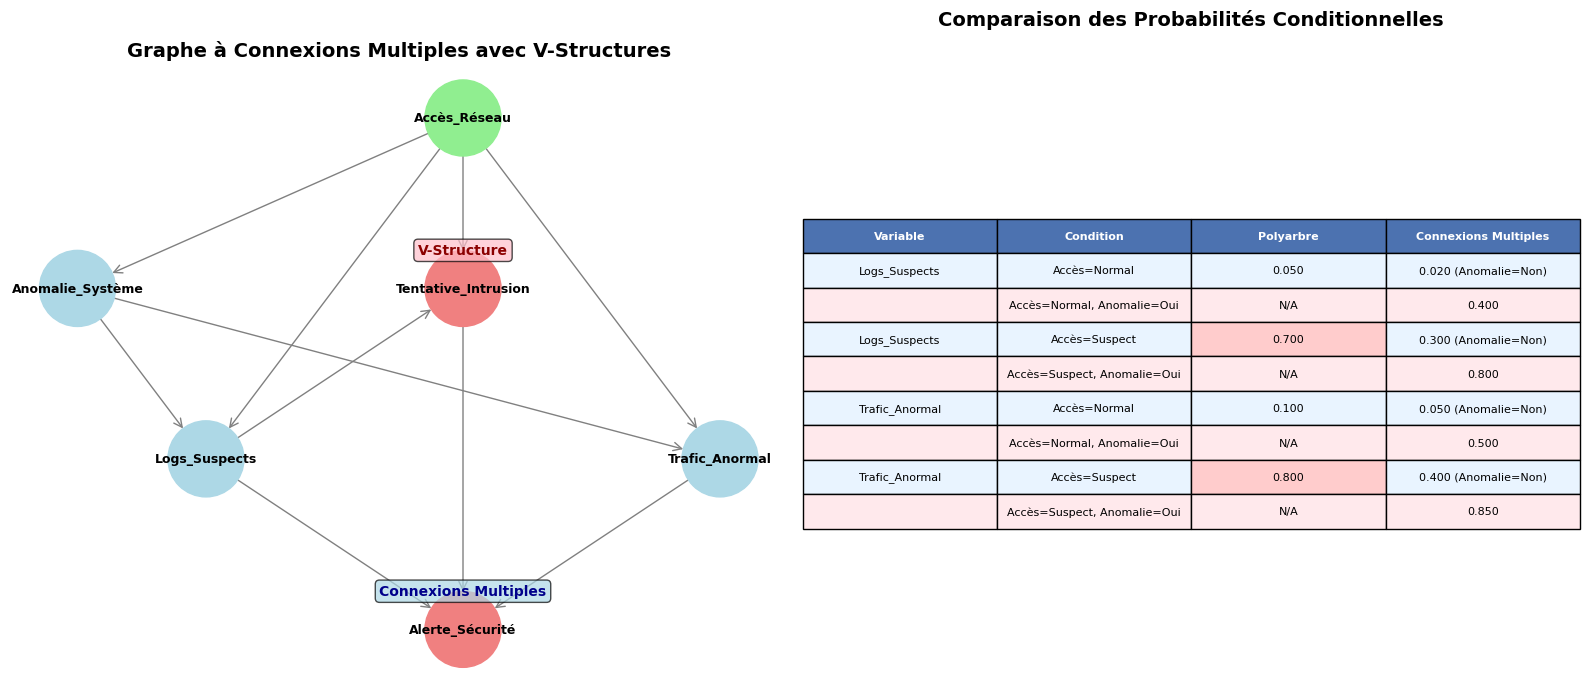


ANALYSE DES V-STRUCTURES ET CONNEXIONS MULTIPLES

1. Analyse de la V-Structure: Tentative_Intrusion
--------------------------------------------------
Parents: Accès_Réseau et Logs_Suspects
Enfants: Alerte_Sécurité

Sans observation d'Alerte:
  P(Accès=Suspect | Logs=Suspects) = 0.771

Avec observation d'Alerte=Oui:
  P(Accès=Suspect | Logs=Suspects, Alerte=Oui) = 0.876
  Impact: 0.105

Accès suspect                 
  Connexions Multiples: P(Alerte=Oui) = 0.508
  Polyarbre:           P(Alerte=Oui) = 0.643
  Différence:          0.135

Accès suspect + Anomalie      
  Connexions Multiples: P(Alerte=Oui) = 0.672
  Polyarbre:           P(Alerte=Oui) = 0.643
  Différence:          0.029

Logs suspects                 
  Connexions Multiples: P(Alerte=Oui) = 0.687
  Polyarbre:           P(Alerte=Oui) = 0.659
  Différence:          0.028

Trafic anormal                
  Connexions Multiples: P(Alerte=Oui) = 0.445
  Polyarbre:           P(Alerte=Oui) = 0.615
  Différence:          0.170

T

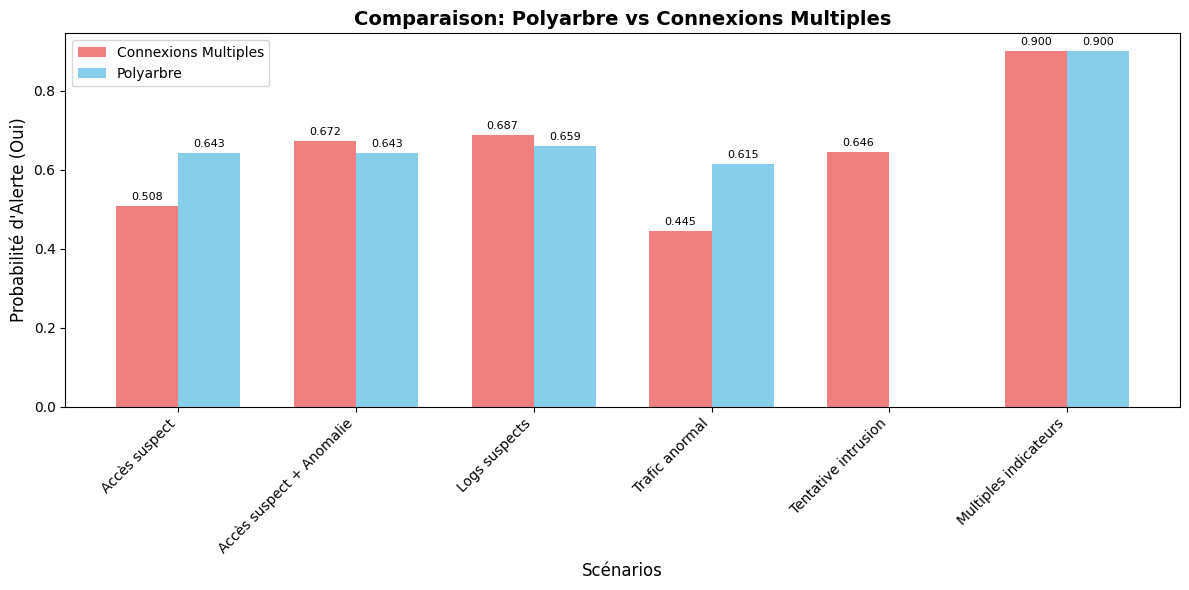


RÉSUMÉ DES DIFFÉRENCES STRUCTURELLES

1. POLYARBRE:
   - Structure arborescente simple
   - Pas de v-structures
   - Chaque nœud a au plus un parent
   - Inférence plus rapide
   - Moins expressif

2. CONNEXIONS MULTIPLES:
   - Structure DAG complexe
   - Présence de v-structures
   - Nœuds peuvent avoir plusieurs parents
   - Modélise des relations réalistes
   - Capture des dépendances conditionnelles
   - Inférence plus complexe mais plus précise

3. V-STRUCTURES DÉTECTÉES:
   - Tentative_Intrusion ← Accès_Réseau → Logs_Suspects
   - Alerte_Sécurité ← Logs_Suspects → Trafic_Anormal (indirect)


In [17]:
# ============ GRAPHE À CONNEXIONS MULTIPLES ============
print("\n" + "=" * 70)
print("ÉTAPE 3 : GRAPHE À CONNEXIONS MULTIPLES - VISUALISATIONS")
print("=" * 70)

# Création du modèle complexe
connexions_multiples = DiscreteBayesianNetwork([
    ('Accès_Réseau', 'Logs_Suspects'),
    ('Accès_Réseau', 'Trafic_Anormal'),
    ('Accès_Réseau', 'Anomalie_Système'),
    ('Accès_Réseau', 'Tentative_Intrusion'),
    ('Logs_Suspects', 'Tentative_Intrusion'),
    ('Anomalie_Système', 'Logs_Suspects'),
    ('Anomalie_Système', 'Trafic_Anormal'),
    ('Logs_Suspects', 'Alerte_Sécurité'),
    ('Trafic_Anormal', 'Alerte_Sécurité'),
    ('Tentative_Intrusion', 'Alerte_Sécurité')
])

# Distributions conditionnelles simplifiées mais correctes
cpd_acces_reseau_mc = TabularCPD(
    variable='Accès_Réseau', variable_card=2,
    values=[[0.85], [0.15]],
    state_names={'Accès_Réseau': ['Normal', 'Suspect']}
)

cpd_anomalie_systeme = TabularCPD(
    variable='Anomalie_Système', variable_card=2,
    values=[[0.97, 0.40], [0.03, 0.60]],
    evidence=['Accès_Réseau'], evidence_card=[2],
    state_names={'Anomalie_Système': ['Non', 'Oui'],
                 'Accès_Réseau': ['Normal', 'Suspect']}
)

cpd_logs_suspects_mc = TabularCPD(
    variable='Logs_Suspects', variable_card=2,
    values=[[0.98, 0.60, 0.70, 0.20],
            [0.02, 0.40, 0.30, 0.80]],
    evidence=['Accès_Réseau', 'Anomalie_Système'],
    evidence_card=[2, 2],
    state_names={'Logs_Suspects': ['Normal', 'Suspects'],
                 'Accès_Réseau': ['Normal', 'Suspect'],
                 'Anomalie_Système': ['Non', 'Oui']}
)

cpd_trafic_anormal_mc = TabularCPD(
    variable='Trafic_Anormal', variable_card=2,
    values=[[0.95, 0.50, 0.60, 0.15],
            [0.05, 0.50, 0.40, 0.85]],
    evidence=['Accès_Réseau', 'Anomalie_Système'],
    evidence_card=[2, 2],
    state_names={'Trafic_Anormal': ['Normal', 'Anormal'],
                 'Accès_Réseau': ['Normal', 'Suspect'],
                 'Anomalie_Système': ['Non', 'Oui']}
)

cpd_tentative_intrusion = TabularCPD(
    variable='Tentative_Intrusion', variable_card=2,
    values=[[0.99, 0.70, 0.60, 0.10],
            [0.01, 0.30, 0.40, 0.90]],
    evidence=['Accès_Réseau', 'Logs_Suspects'],
    evidence_card=[2, 2],
    state_names={'Tentative_Intrusion': ['Non', 'Oui'],
                 'Accès_Réseau': ['Normal', 'Suspect'],
                 'Logs_Suspects': ['Normal', 'Suspects']}
)

# CPD d'Alerte avec valeurs 2D correctes
cpd_alerte_securite_mc = TabularCPD(
    variable='Alerte_Sécurité', variable_card=2,
    values=[
        [0.999, 0.90, 0.95, 0.70, 0.80, 0.40, 0.60, 0.10],  # P(Non|...)
        [0.001, 0.10, 0.05, 0.30, 0.20, 0.60, 0.40, 0.90]   # P(Oui|...)
    ],
    evidence=['Logs_Suspects', 'Trafic_Anormal', 'Tentative_Intrusion'],
    evidence_card=[2, 2, 2],
    state_names={'Alerte_Sécurité': ['Non', 'Oui'],
                 'Logs_Suspects': ['Normal', 'Suspects'],
                 'Trafic_Anormal': ['Normal', 'Anormal'],
                 'Tentative_Intrusion': ['Non', 'Oui']}
)

connexions_multiples.add_cpds(
    cpd_acces_reseau_mc, cpd_anomalie_systeme,
    cpd_logs_suspects_mc, cpd_trafic_anormal_mc,
    cpd_tentative_intrusion, cpd_alerte_securite_mc
)

# ============ VISUALISATION 1 : GRAPHE COMPLEXE ============
fig3, axes2 = plt.subplots(1, 2, figsize=(16, 7))

# Sous-graphique 1 : Structure avec v-structures
ax4 = axes2[0]
G_complex = nx.DiGraph()

# Positions pour mettre en évidence les v-structures
pos_complex = {
    'Accès_Réseau': (0, 2),
    'Anomalie_Système': (-1.5, 1),
    'Logs_Suspects': (-1, 0),
    'Trafic_Anormal': (1, 0),
    'Tentative_Intrusion': (0, 1),
    'Alerte_Sécurité': (0, -1)
}

G_complex.add_edges_from([
    ('Accès_Réseau', 'Logs_Suspects'),
    ('Accès_Réseau', 'Trafic_Anormal'),
    ('Accès_Réseau', 'Anomalie_Système'),
    ('Accès_Réseau', 'Tentative_Intrusion'),
    ('Logs_Suspects', 'Tentative_Intrusion'),  # V-structure
    ('Anomalie_Système', 'Logs_Suspects'),
    ('Anomalie_Système', 'Trafic_Anormal'),
    ('Logs_Suspects', 'Alerte_Sécurité'),
    ('Trafic_Anormal', 'Alerte_Sécurité'),
    ('Tentative_Intrusion', 'Alerte_Sécurité')
])

# Couleurs spéciales pour les v-structures
node_colors = []
for node in G_complex.nodes():
    if node in ['Tentative_Intrusion', 'Alerte_Sécurité']:
        node_colors.append('lightcoral')  # V-structures en rouge clair
    elif node == 'Accès_Réseau':
        node_colors.append('lightgreen')  # Racine en vert
    else:
        node_colors.append('lightblue')

nx.draw(G_complex, pos_complex, ax=ax4, with_labels=True, 
        node_size=3000, node_color=node_colors, font_size=9, 
        font_weight='bold', arrowsize=15, arrowstyle='->',
        edge_color='gray')

# Marquage des v-structures
ax4.text(0, 1.2, "V-Structure", fontsize=10, fontweight='bold', 
         ha='center', color='darkred', bbox=dict(boxstyle="round,pad=0.3", 
         facecolor="pink", alpha=0.7))
ax4.text(0, -0.8, "Connexions Multiples", fontsize=10, fontweight='bold',
         ha='center', color='darkblue', bbox=dict(boxstyle="round,pad=0.3",
         facecolor="lightblue", alpha=0.7))

ax4.set_title("Graphe à Connexions Multiples avec V-Structures", 
              fontsize=14, fontweight='bold')

# ============ VISUALISATION 2 : COMPARAISON DES CPDs ============
ax5 = axes2[1]
ax5.axis('off')

# Données pour la comparaison CPDs simples vs complexes
comparison_data = []
headers_comparison = ["Variable", "Condition", "Polyarbre", "Connexions Multiples"]

# Comparaison pour Logs_Suspects
for i, acces in enumerate(['Normal', 'Suspect']):
    poly_val = cpd_logs_suspects.get_values()[1,i]  # P(Suspects)
    mc_val = cpd_logs_suspects_mc.get_values()[1,i*2]  # P(Suspects|Anomalie=Non)
    
    comparison_data.append([
        "Logs_Suspects",
        f"Accès={acces}",
        f"{poly_val:.3f}",
        f"{mc_val:.3f} (Anomalie=Non)"
    ])
    
    # Deuxième ligne pour Anomalie=Oui
    mc_val_oui = cpd_logs_suspects_mc.get_values()[1,i*2 + 1]
    comparison_data.append([
        "",
        f"Accès={acces}, Anomalie=Oui",
        "N/A",
        f"{mc_val_oui:.3f}"
    ])

# Comparaison pour Trafic_Anormal
for i, acces in enumerate(['Normal', 'Suspect']):
    poly_val = cpd_trafic_anormal.get_values()[1,i]  # P(Anormal)
    mc_val = cpd_trafic_anormal_mc.get_values()[1,i*2]  # P(Anormal|Anomalie=Non)
    
    comparison_data.append([
        "Trafic_Anormal",
        f"Accès={acces}",
        f"{poly_val:.3f}",
        f"{mc_val:.3f} (Anomalie=Non)"
    ])
    
    # Deuxième ligne pour Anomalie=Oui
    mc_val_oui = cpd_trafic_anormal_mc.get_values()[1,i*2 + 1]
    comparison_data.append([
        "",
        f"Accès={acces}, Anomalie=Oui",
        "N/A",
        f"{mc_val_oui:.3f}"
    ])

# Tableau de comparaison
table2 = ax5.table(cellText=comparison_data, colLabels=headers_comparison,
                   cellLoc='center', loc='center',
                   colColours=['#f0f0f0']*4)

table2.auto_set_font_size(False)
table2.set_fontsize(8)
table2.scale(1, 1.8)

# Style alterné
for i in range(len(comparison_data)+1):
    for j in range(4):
        cell = table2[(i, j)]
        if i == 0:
            cell.set_facecolor('#4c72b0')
            cell.set_text_props(weight='bold', color='white')
        elif i % 2 == 1:
            cell.set_facecolor('#e9f4ff')  # Bleu clair pour polyarbre
        else:
            cell.set_facecolor('#ffe9ec')  # Rose clair pour connexions multiples
        
        # Mettre en évidence les différences
        if i > 0 and j == 2 and comparison_data[i-1][j] != "N/A":
            poly_val = float(comparison_data[i-1][j])
            mc_val = float(comparison_data[i-1][3].split(' ')[0])
            if abs(poly_val - mc_val) > 0.1:
                cell.set_facecolor('#ffcccc')

ax5.set_title("Comparaison des Probabilités Conditionnelles", 
              fontsize=14, fontweight='bold', y=1.05)

plt.tight_layout()
plt.show()

# ============ VISUALISATION 3 : ANALYSE DES V-STRUCTURES ============
print("\n" + "=" * 70)
print("ANALYSE DES V-STRUCTURES ET CONNEXIONS MULTIPLES")
print("=" * 70)

inference_mc = VariableElimination(connexions_multiples)

# Analyse d'une v-structure : Tentative_Intrusion
print("\n1. Analyse de la V-Structure: Tentative_Intrusion")
print("-" * 50)
print("Parents: Accès_Réseau et Logs_Suspects")
print("Enfants: Alerte_Sécurité")

# Sans observation de l'enfant
prob_sans = inference_mc.query(
    variables=['Accès_Réseau'],
    evidence={'Logs_Suspects': 'Suspects'}
)
print(f"\nSans observation d'Alerte:")
print(f"  P(Accès=Suspect | Logs=Suspects) = {prob_sans.values[1]:.3f}")

# Avec observation de l'enfant
prob_avec = inference_mc.query(
    variables=['Accès_Réseau'],
    evidence={'Logs_Suspects': 'Suspects', 'Alerte_Sécurité': 'Oui'}
)
print(f"\nAvec observation d'Alerte=Oui:")
print(f"  P(Accès=Suspect | Logs=Suspects, Alerte=Oui) = {prob_avec.values[1]:.3f}")
print(f"  Impact: {abs(prob_sans.values[1] - prob_avec.values[1]):.3f}")

# ============ VISUALISATION 4 : IMPACT DES CONNEXIONS MULTIPLES ============
fig4, ax6 = plt.subplots(figsize=(12, 6))

# Scénarios complexes
scenarios_complexes = [
    ("Accès suspect", {"Accès_Réseau": "Suspect"}),
    ("Accès suspect + Anomalie", {"Accès_Réseau": "Suspect", "Anomalie_Système": "Oui"}),
    ("Logs suspects", {"Logs_Suspects": "Suspects"}),
    ("Trafic anormal", {"Trafic_Anormal": "Anormal"}),
    ("Tentative intrusion", {"Tentative_Intrusion": "Oui"}),
    ("Multiples indicateurs", {"Logs_Suspects": "Suspects", 
                               "Trafic_Anormal": "Anormal",
                               "Tentative_Intrusion": "Oui"})
]

scenario_names_mc = []
prob_alertes_mc = []
prob_alertes_poly = []  # Pour comparaison

inference_poly = VariableElimination(polyarbre_securite)

for i, (nom, evidence) in enumerate(scenarios_complexes):
    # Calcul pour connexions multiples
    result_mc = inference_mc.query(variables=['Alerte_Sécurité'], 
                                   evidence=evidence if evidence else None)
    prob_mc = result_mc.values[1]
    
    # Calcul pour polyarbre (si applicable)
    evidence_poly = {k: v for k, v in evidence.items() 
                     if k in ['Accès_Réseau', 'Logs_Suspects', 'Trafic_Anormal']}
    if evidence_poly:
        result_poly = inference_poly.query(variables=['Alerte_Sécurité'], 
                                           evidence=evidence_poly)
        prob_poly = result_poly.values[1]
    else:
        prob_poly = None
    
    scenario_names_mc.append(nom)
    prob_alertes_mc.append(prob_mc)
    prob_alertes_poly.append(prob_poly)
    
    print(f"\n{nom:30}")
    print(f"  Connexions Multiples: P(Alerte=Oui) = {prob_mc:.3f}")
    if prob_poly is not None:
        print(f"  Polyarbre:           P(Alerte=Oui) = {prob_poly:.3f}")
        print(f"  Différence:          {abs(prob_mc - prob_poly):.3f}")

# Graphique comparatif
x = range(len(scenario_names_mc))
width = 0.35

bars_mc = ax6.bar([i - width/2 for i in x], prob_alertes_mc, 
                  width, label='Connexions Multiples', color='lightcoral')
bars_poly = ax6.bar([i + width/2 for i in x], 
                    [p if p is not None else 0 for p in prob_alertes_poly], 
                    width, label='Polyarbre', color='skyblue')

ax6.set_xlabel("Scénarios", fontsize=12)
ax6.set_ylabel("Probabilité d'Alerte (Oui)", fontsize=12)
ax6.set_title("Comparaison: Polyarbre vs Connexions Multiples", 
              fontsize=14, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(scenario_names_mc, rotation=45, ha='right')
ax6.legend()

# Ajout des valeurs
for bars in [bars_mc, bars_poly]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax6.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                     f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# ============ RÉSUMÉ DES DIFFÉRENCES STRUCTURELLES ============
print("\n" + "=" * 70)
print("RÉSUMÉ DES DIFFÉRENCES STRUCTURELLES")
print("=" * 70)

print("\n1. POLYARBRE:")
print("   - Structure arborescente simple")
print("   - Pas de v-structures")
print("   - Chaque nœud a au plus un parent")
print("   - Inférence plus rapide")
print("   - Moins expressif")

print("\n2. CONNEXIONS MULTIPLES:")
print("   - Structure DAG complexe")
print("   - Présence de v-structures")
print("   - Nœuds peuvent avoir plusieurs parents")
print("   - Modélise des relations réalistes")
print("   - Capture des dépendances conditionnelles")
print("   - Inférence plus complexe mais plus précise")

print("\n3. V-STRUCTURES DÉTECTÉES:")
print("   - Tentative_Intrusion ← Accès_Réseau → Logs_Suspects")
print("   - Alerte_Sécurité ← Logs_Suspects → Trafic_Anormal (indirect)")